In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

csv_path = "./final_data.csv"
random_state = 14

N_large = 20000
N_small = 1000
df = pd.read_csv(csv_path, header=None)

X_all = df.iloc[:, :-1]
y_all = df.iloc[:, -1]
X_large = df.iloc[:N_large, :-1]
y_large = df.iloc[:N_large, -1]
X_small = df.iloc[:N_small, :-1]
y_small = df.iloc[:N_small, -1]

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

regressors = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=random_state),
    'Gradient Boosting': GradientBoostingRegressor(random_state=random_state),
    'Decision Tree': DecisionTreeRegressor(random_state=random_state),
    'KNN': KNeighborsRegressor(),
    "XGBoost": XGBRegressor(random_state=random_state)
}
regressor_names = regressors.keys()

## Train Models

### Primeres prediccions

In [3]:
# Creem PCA datasets
pca_2 = PCA(n_components=2, random_state=random_state)
X_data_pca_2 = pca_2.fit_transform(X_large)
pca_6 = PCA(n_components=6, random_state=random_state)
X_data_pca_6 = pca_6.fit_transform(X_large)
pca_12 = PCA(n_components=12, random_state=random_state)
X_data_pca_12 = pca_12.fit_transform(X_large)

data_list = [['Original',X_large], ['PCA 2 components',X_data_pca_2], ['PCA 6 components',X_data_pca_6], ['PCA 12 components',X_data_pca_12]]

# Define the scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
folds = KFold(n_splits = 5, shuffle = True, random_state = random_state)

# Store results
results = []
scores_for_dataset = {name: [] for name in regressor_names}
sum_mae_per_dataset = {name: {} for name in regressor_names}

# Model evaluation loop
for name, reg in regressors.items():
    print(f"---------------------Starting {name}----------------------------")
    for dataset in data_list:
        # Perform cross-validation and compute the average MAE score
        scores = cross_val_score(reg, dataset[1], y_large, cv=folds, scoring=mae_scorer)
        avg_score = -np.mean(scores)
        results.append({
            'Regressor': name,
            'Average MAE': avg_score,
            'Dataset': dataset[0]
        })
        print(f'{name}: Average MAE = {avg_score:.4f} Dataset: {dataset[0]}')
        scores_for_dataset[name].append(avg_score)
        
        if dataset[0] not in sum_mae_per_dataset[name]:
            sum_mae_per_dataset[name][dataset[0]] = avg_score
        else:
            sum_mae_per_dataset[name][dataset[0]] += avg_score

# Convert results into DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Find the best dataset for each model based on the sum of MAE scores
best_datasets_per_model = {}
for model, dataset_scores in sum_mae_per_dataset.items():
    best_dataset = min(dataset_scores, key=dataset_scores.get)  # Minimize MAE (lower is better)
    best_mae_sum = dataset_scores[best_dataset]
    best_datasets_per_model[model] = {'Dataset': best_dataset, 'MAE Sum': best_mae_sum}

# Print the best dataset for each model
print("\nBest dataset for each regressor:")
for model, info in best_datasets_per_model.items():
    print(f"Regressor: {model} | Best Dataset: {info['Dataset']}")

# Identify the best regressor based on the average MAE
best_regressor = results_df.loc[results_df['Average MAE'].idxmin()]  # Minimize MAE
print("\nBest model (with default parameters):")
print(f"Regressor: {best_regressor['Regressor']}")
print(f"Average MAE: {best_regressor['Average MAE']:.4f}")

---------------------Starting Linear Regression----------------------------
Linear Regression: Average MAE = 438297.5101 Dataset: Original
Linear Regression: Average MAE = 1.5074 Dataset: PCA 2 components
Linear Regression: Average MAE = 1.4390 Dataset: PCA 6 components
Linear Regression: Average MAE = 1.4334 Dataset: PCA 12 components
---------------------Starting Lasso----------------------------
Lasso: Average MAE = 1.5095 Dataset: Original
Lasso: Average MAE = 1.5095 Dataset: PCA 2 components
Lasso: Average MAE = 1.5095 Dataset: PCA 6 components
Lasso: Average MAE = 1.5095 Dataset: PCA 12 components
---------------------Starting Ridge----------------------------
Ridge: Average MAE = 0.9590 Dataset: Original
Ridge: Average MAE = 1.5074 Dataset: PCA 2 components
Ridge: Average MAE = 1.4390 Dataset: PCA 6 components
Ridge: Average MAE = 1.4334 Dataset: PCA 12 components
---------------------Starting SVR----------------------------
SVR: Average MAE = 0.9252 Dataset: Original
SVR: Avera

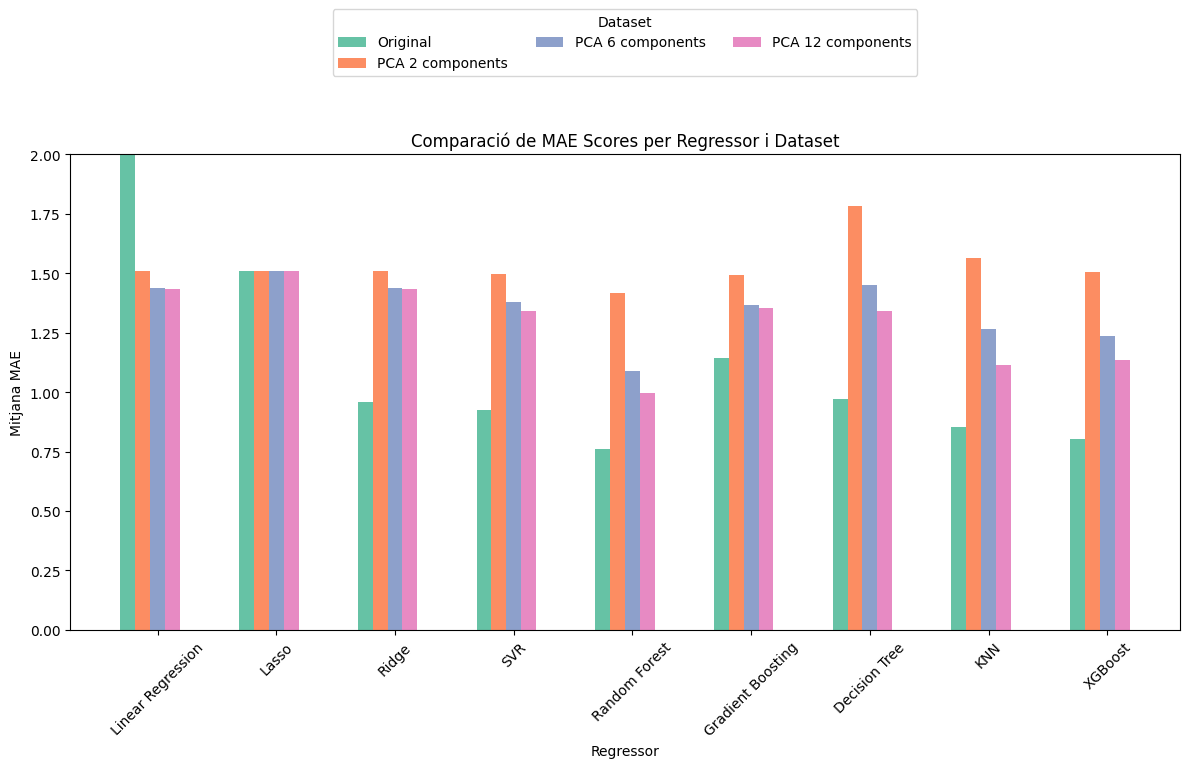

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = sns.color_palette("Set2", len(results_df['Dataset'].unique()))

bar_width = 0.15

separation_factor = 1.2
positions = np.arange(len(regressor_names)) * separation_factor

for i, dataset in enumerate(data_list):
    subset = results_df[results_df['Dataset'] == dataset[0]]
    ax.bar(positions + i * bar_width, subset['Average MAE'], width=bar_width, label=dataset[0], color=colors[i])

ax.set_xlabel('Regressor')
ax.set_ylabel('Mitjana MAE')
ax.set_title('Comparació de MAE Scores per Regressor i Dataset')

ax.set_xticks(positions + bar_width * (len(data_list) / 2))
ax.set_xticklabels(regressor_names, rotation=45)

ax.legend(title='Dataset', bbox_to_anchor=(0.5, 1.15), loc='lower center', ncol=3)
ax.set_ylim(0, 2)

plt.tight_layout()

plt.show()

### Cerca d'hiperparàmetres

In [5]:
import time
from sklearn.model_selection import GridSearchCV, KFold

random_state=27
def hyperparameters_search(regressors, param_grids, data_list, y_data, cv_splits=5):
    kfold = KFold(n_splits = cv_splits, shuffle = True, random_state = random_state)
    results = []
    for data in data_list:
        dataset_name = data[0]
        print(f'DATASET: {dataset_name}')
        X = data[1]
        for name, model in regressors.items():
            print(f"\nEvaluant {type(model).__name__}")        
            
            start_time = time.time()  
            gs = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=kfold, 
                  scoring='neg_mean_absolute_error', n_jobs=-1)
            gs.fit(X, y_data)
            cv_results = gs.cv_results_
            best_index = gs.best_index_
            mean_mae_best_model = -cv_results['mean_test_score'][best_index]
            best_params = gs.best_params_
            end_time = time.time()  
            calc_time = end_time - start_time 

            results.append({
                'Dataset': dataset_name,
                'Regressor': name,
                'Mean Test Score (MAE)': mean_mae_best_model,
                'Execution Time (s)': calc_time,  
                'Best Parameters': best_params,
                'Best Estimator': gs.best_estimator_  
            })
            print(f'Dataset: {dataset_name}, Regressor: {type(model).__name__}, Mean Test Score: {mean_mae_best_model:.4f}, Time: {calc_time:.2f}s')

    return pd.DataFrame(results)

In [6]:
# Paràmetres pel Linear Regression (no hyperparameters to tune for basic Linear Regression)
lr_param_grid = {}

# Paràmetres pel Lasso Regression
lasso_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
}

# Paràmetres pel Ridge Regression
ridge_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
}

# Paràmetres pel SVR
svr_param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5],  # Insensitivity zone
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (for 'poly')
}

# Paràmetres pel Random Forest Regressor
rfr_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [2, 'sqrt', 'log2']
}

# Paràmetres pel Gradient Boosting Regressor
gbr_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Paràmetres pel Decision Tree Regressor
dtr_param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Paràmetres pel KNN Regressor
knn_param_grid = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Paràmetres pel XGBoost Regressor
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Compile all parameter grids into a dictionary
param_grid_list = {
    'Linear Regression': lr_param_grid,
    'Lasso': lasso_param_grid,
    'Ridge': ridge_param_grid,
    'SVR': svr_param_grid,
    'Random Forest': rfr_param_grid,
    'Gradient Boosting': gbr_param_grid,
    'Decision Tree': dtr_param_grid,
    'KNN': knn_param_grid,
    'XGBoost': xgb_param_grid
}


In [7]:
results_df = hyperparameters_search(regressors, param_grid_list, [['Original', X_small]], y_small, cv_splits=5)
results_df.to_csv("hyperparameters_search_results.csv", index=False)

DATASET: Original

Evaluant LinearRegression
Dataset: Original, Regressor: LinearRegression, Mean Test Score: 6631053980.0192, Time: 4.26s

Evaluant Lasso
Dataset: Original, Regressor: Lasso, Mean Test Score: 1.0794, Time: 2.88s

Evaluant Ridge
Dataset: Original, Regressor: Ridge, Mean Test Score: 1.1764, Time: 0.60s

Evaluant SVR
Dataset: Original, Regressor: SVR, Mean Test Score: 1.1519, Time: 1004.77s

Evaluant RandomForestRegressor
Dataset: Original, Regressor: RandomForestRegressor, Mean Test Score: 1.3963, Time: 47.68s

Evaluant GradientBoostingRegressor


c:\Program Files\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Dataset: Original, Regressor: GradientBoostingRegressor, Mean Test Score: 1.3565, Time: 32.62s

Evaluant DecisionTreeRegressor
Dataset: Original, Regressor: DecisionTreeRegressor, Mean Test Score: 1.5443, Time: 1.21s

Evaluant KNeighborsRegressor
Dataset: Original, Regressor: KNeighborsRegressor, Mean Test Score: 1.3616, Time: 80.02s

Evaluant XGBRegressor


c:\Program Files\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Dataset: Original, Regressor: XGBRegressor, Mean Test Score: 1.2061, Time: 405.45s


### Anàlisi dels resultats

In [6]:
results_df = pd.read_csv('hyperparameters_search_results.csv')

C:\Users\adtro\AppData\Local\Temp\ipykernel_22288\2401824620.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


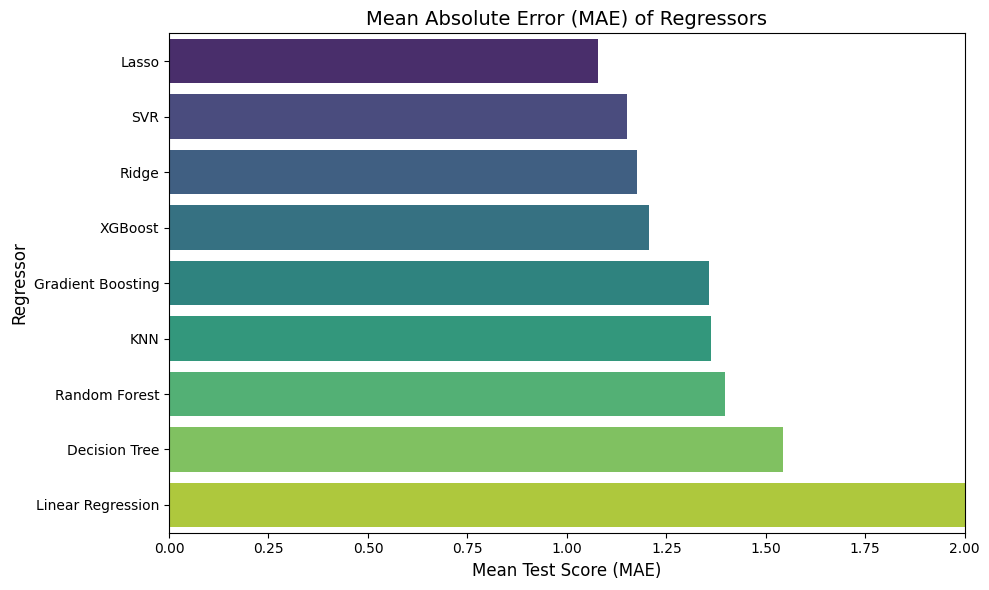

In [7]:
# results_df['Model Type'] = results_df['Regressor'].apply(lambda x: x.split()[0])

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean Test Score (MAE)',
    y='Regressor',
    data=results_df,
    palette='viridis',
    order=results_df.sort_values('Mean Test Score (MAE)')['Regressor']
)

# Plot settings
plt.title('Mean Absolute Error (MAE) of Regressors', fontsize=14)
plt.xlabel('Mean Test Score (MAE)', fontsize=12)
plt.ylabel('Regressor', fontsize=12)
plt.xlim(0, 2) 
plt.tight_layout()

# Show the plot
plt.show()

#### Anàlisi del millor model:

In [8]:
models_no_init = {
    'Linear Regression': LinearRegression,
    'Lasso': Lasso,
    'Ridge': Ridge,
    'SVR': SVR,
    'Random Forest': RandomForestRegressor,
    'Gradient Boosting': GradientBoostingRegressor,
    'Decision Tree': DecisionTreeRegressor,
    'KNN': KNeighborsRegressor,
    "XGBoost": XGBRegressor
}

In [9]:
best_model_df = results_df.groupby(['Regressor', 'Dataset']).agg(
    Avg_Test_Score=('Mean Test Score (MAE)', 'mean'),
    Best_Params=('Best Parameters', 'first')
).reset_index()

best_model_row = best_model_df.loc[best_model_df['Avg_Test_Score'].idxmin()]

best_model_name = best_model_row['Regressor']
best_model_params = eval(best_model_row['Best_Params']) 
model_class = models_no_init[best_model_name]
best_model = model_class(**best_model_params) 
best_model_row = best_model_df.loc[best_model_df['Avg_Test_Score'].idxmin()]

In [11]:
best_model

Lasso(alpha=0.01)

In [10]:
best_model_row

Regressor                   Lasso
Dataset                  Original
Avg_Test_Score           1.079384
Best_Params       {'alpha': 0.01}
Name: 3, dtype: object

In [12]:
# Perform cross-validation and compute the average MAE score
def train_model(regressor, X, y):
    folds = KFold(n_splits = 5, shuffle = True, random_state = random_state)
    scores = cross_val_score(regressor, X, y, cv=folds, scoring='neg_mean_absolute_error')
    avg_score = -np.mean(scores)
    print(f'{str(regressor)}: Average MAE = {avg_score:.4f}')

In [13]:
train_model(best_model, X_all, y_all)

Lasso(alpha=0.01): Average MAE = 1.0198


### Model final i resultats

In [55]:
linear_regressor = LassoCV()
linear_regressor.fit(X_all, y_all)

c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.575e+04, tolerance: 5.087e+01
  model = cd_fast.enet_coordinate_descent(


LassoCV()

In [56]:
print(mean_absolute_error(y_all, linear_regressor.predict(X_all)))
print(len(linear_regressor.coef_))
linear_regressor.coef_

0.9358439843581661
780


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.04094774e+00,  7.31566224e-01,  1.48086230e+00,  7.37974313e-01,
        1.72985214e-01,  6.27169095e-01,  4.82232327e-01,  1.17793829e+00,
        2.72831616e-01,  7.74870189e-01,  6.04642755e-01,  7.61751642e-01,
        1.02232084e-01,  2.65907055e-01,  2.56836401e-01,  5.23658596e-02,
        7.55905911e-03,  3.20473855e-01, -0.00000000e+00, -2.32775704e-03,
        8.98941540e-02,  2.06250365e-02,  2.68144595e-02,  7.95792675e-02,
       -1.51321429e-01, -5.06977925e-03, -3.35931988e-02, -2.56355506e-03,
        3.72099157e-02, -1.02198816e-03, -5.30607973e-02, -1.95616882e-01,
       -1.84596333e-01, -1.43379825e-01, -1.34181659e-01, -0.00000000e+00,
       -6.31007916e-02, -2.39557347e-01,  1.09300440e-02, -1.74877057e-01,
       -1.03562236e-01, -1.71002874e-02, -1.63277623e-01, -2.50660260e-01,
       -8.31284859e-02, -

In [16]:
linear_regressor.alpha_

np.float64(0.0005439151491175198)

In [17]:
sum(linear_regressor.coef_ != 0) / len(linear_regressor.coef_)

np.float64(0.632051282051282)

In [21]:
coeficients_modificats = linear_regressor.coef_.__copy__()
coeficients_modificats /= linear_regressor.coef_[768]
coeficients_modificats

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.16338596e+00,  8.17614414e-01,  1.65504410e+00,  8.24776234e-01,
        1.93332059e-01,  7.00937899e-01,  5.38953397e-01,  1.31648960e+00,
        3.04922582e-01,  8.66011873e-01,  6.75761969e-01,  8.51350298e-01,
        1.14256813e-01,  2.97183541e-01,  2.87045980e-01,  5.85252301e-02,
        8.44816981e-03,  3.58168590e-01, -0.00000000e+00, -2.60155218e-03,
        1.00467673e-01,  2.30509920e-02,  2.99684264e-02,  8.89395301e-02,
       -1.69120139e-01, -5.66609619e-03, -3.75444938e-02, -2.86508521e-03,
        4.15866157e-02, -1.14219633e-03, -5.93019078e-02, -2.18625706e-01,
       -2.06308900e-01, -1.60244429e-01, -1.49964357e-01, -0.00000000e+00,
       -7.05228250e-02, -2.67734531e-01,  1.22156563e-02, -1.95446424e-01,
       -1.15743420e-01, -1.91116553e-02, -1.82482643e-01, -2.80143390e-01,
       -9.29062142e-02, -

In [44]:
# Per tal d'anailtzar qualitativament els resultats
n = 64 * 0
coeficients_modificats[n:n+64].reshape((8,8)) > 0

array([[False, False, False, False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False]])

In [46]:
# Avaluació de la posició inicial
posicio_inicial = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 2, 2, 1, 1, 8, 2, 2, 2, 1, 1])
linear_regressor.coef_.dot(posicio_inicial) + linear_regressor.intercept_

np.float64(0.1235773811105762)

In [18]:
import json

# Save coefficients and intercept to JSON
model_data = {
    "coefficients": linear_regressor.coef_.tolist(),
    "intercept": linear_regressor.intercept_
}

with open("linear_model.json", "w") as f:
    json.dump(model_data, f)

print("Model saved to linear_model.json")

Model saved to linear_model.json


In [76]:
from sklearn.metrics import r2_score

r2_score(linear_regressor.predict(X_all), y_all)

0.5422723913856675

### Modificacions

In [49]:
def calc_new_values(white_value, black_value):
    # Calcular la mitjana del valor absolut
    mean_abs = (abs(white_value) + abs(black_value)) / 2
    
    if np.sign(white_value) != np.sign(black_value):
        # Manté els signes originals
        return (np.sign(white_value) * mean_abs, np.sign(black_value) * mean_abs)
    else:
        # Substitueix amb 0 si tenen el mateix signe
        return (0, 0)

In [71]:
# Exemple d'array de longitud 780
coeficients_millorats = linear_regressor.coef_.__copy__()

# Constants per representar les columnes
pawn_white_value = coeficients_millorats[768]
pawn_black_value = np.abs(coeficients_millorats[774])

# 1. Escalar els coeficients relacionats amb les peces blanques i negres
coeficients_millorats[:384] /= pawn_white_value
coeficients_millorats[768:774] /= pawn_white_value

coeficients_millorats[384:768] /= pawn_black_value
coeficients_millorats[774:780] /= pawn_black_value

# 2. Substituir pel valor mitjà absolut amb la simetria horitzontal
for i in range(384):
    piece = i//64; square = i%64; row = square//8; col = square%8
    white_value = coeficients_millorats[i]
    black_value = coeficients_millorats[384 + (7-row)*8+col + 64*piece]
    # print(square, (7-row)*8+col)
    
    new_vals = calc_new_values(white_value, black_value)
    coeficients_millorats[i] = new_vals[0]
    coeficients_millorats[384 + (7-row)*8+col + 64*piece] = new_vals[1]

for i in range(768, 774):
    white_value = coeficients_millorats[i]
    black_value = coeficients_millorats[6 + i]
    
    new_vals = calc_new_values(white_value, black_value)
    coeficients_millorats[i] = new_vals[0]
    coeficients_millorats[6 + i] = new_vals[1]

# Imprimir el resultat final
coeficients_millorats

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.03280156e+00,  1.21047805e+00,  1.69240320e+00,  8.38155268e-01,
        8.39217199e-01,  1.18261659e+00,  1.01734344e+00,  7.78059247e-01,
        2.42919402e-01,  6.72724747e-01,  6.63451713e-01,  8.75234343e-01,
        8.41115216e-02,  4.45212944e-01,  3.15405777e-01,  1.83614354e-01,
        0.00000000e+00,  2.28312697e-01,  0.00000000e+00,  0.00000000e+00,
        7.62865438e-02,  1.15254960e-02,  1.02270414e-01,  4.44697651e-02,
       -1.26729375e-01, -2.83304809e-03, -3.01947514e-02,  0.00000000e+00,
        5.12693656e-02,  0.00000000e+00,  0.00000000e+00, -1.21206131e-01,
       -1.81575111e-01, -1.37618545e-01, -1.35570360e-01,  0.00000000e+00,
       -6.60654026e-02, -1.70041061e-01,  6.87905150e-02, -1.06358204e-01,
       -6.79314797e-02, -5.66131281e-02, -1.94810174e-01, -2.06471585e-01,
       -5.67003645e-02,  

In [72]:
coeficients_millorats[384:]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.79314797e-02,  5.66131281e-02,  1.94810174e-01,  2.06471585e-01,
        5.67003645e-02,  0.00000000e+00, -1.46762549e-01,  0.00000000e+00,
        1.81575111e-01,  1.37618545e-01,  1.35570360e-01,  3.40815466e-02,
        6.60654026e-02,  1.70041061e-01, -6.87905150e-02,  1.06358204e-01,
        1.26729375e-01,  0.00000000e+00,  3.01947514e-02,  0.00000000e+00,
       -5.12693656e-02,  0.00000000e+00,  0.00000000e+00,  1.21206131e-01,
        0.00000000e+00, -2.28312697e-01,  2.08476244e-03,  0.00000000e+00,
       -7.62865438e-02,  0.00000000e+00, -1.02270414e-01,  0.00000000e+00,
       -2.42919402e-01, -6.72724747e-01, -6.63451713e-01, -8.75234343e-01,
       -8.41115216e-02, -4.45212944e-01, -3.15405777e-01, -1.83614354e-01,
       -1.03280156e+00, -1.21047805e+00, -1.69240320e+00, -8.38155268e-01,
       -8.39217199e-01, -

In [73]:
coeficients_millorats.dot(posicio_inicial)

np.float64(0.01999746819821091)

In [74]:
import json

# Save coefficients and intercept to JSON
model_data = {
    "coefficients": coeficients_millorats.tolist(),
    "intercept": 0.0
}

with open("linear_model_modified.json", "w") as f:
    json.dump(model_data, f)

print("Model saved to linear_model.json")

Model saved to linear_model.json
